---
<h1 align="center"><span style='font-family:Georgia'> Replicate Informer on the Four ETDataset </span></h1>
    
---

Informer is a deep learning model designed for long sequence time-series forecasting. It was proposed in the paper [Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting](https://arxiv.org/abs/2012.07436) by Haoyi Zhou, et al.

<img width="800" src="Images/informer.png" alt="Informer Architecture" />

---
## Inputs and Outputs
---
##### **Input sequence:**
The input to the Informer model is a time series sequence of fixed length. The sequence contains a set of features, where each feature corresponds to a value measured at a specific time step in the sequence. 
- The length of the input sequence is defined by the `seq_len` hyperparameter.

##### **Output sequence:**

The output of the Informer model is a time series sequence of predicted values, where each value corresponds to a prediction made at a specific time step in the output sequence. 
- The length of the output sequence is defined by the `pred_len` hyperparameter.

---
## Methodology
---
This notebook provide a step-by-step guide for replicating the **Informer** model and training it on the ETDataset (ETTh1, ETTh2, ETTm1, and ETTm2), ensuring accurate reproduction of the models by comparing the notebook results with the official paper results. The main foucs here is to study the *impact of number of prediction length on the performance*. The workflow from the beginning to forcasting is as follows:

### 1.	Data Preprocessing
The data preprocessing steps mentioned in (Zeng, 2023) include normalization with zero-mean, and seasonal-trend decomposition. 
### 2.	Encoding the data (Data Embedding)
The input data is performed by the `enc_embedding` component, which embeds the input time series values, timestamps (temporal embedding), and their positions (postional embeddig) in the sequence. 

- Positional Embedding: Incorporate temporal information by adding a fixed vector representation to each time step to indicate its position, using a combination of sine and cosine signals with differently increasing frequencies to capture unique temporal dynamics.

- Temporal Embedding: Incorporate a vector that represents the time stamp of each data point in the sequence. The purpose of temporal embedding is to provide the model with explicit information about time dynamics, such as the periodicity, trend, or seasonality of the data. 

### 3.	Encoder
A stack of self-attention layers. Each one consists of multiple attention heads that operate in parallel, allowing the model to capture different aspects of the input sequence. Each encoder layer consists of:

- ProbSparse self-attention layer: used to attend to the previous outputs of the encoder. This is an attention mechanism used in Informer that selects the "active" queries rather than the "lazy" queries. It forms a sparse Transformer by the probability distribution, which reduces the computational cost of the attention operation.
- Conv1d layer: used to reduce the dimensionality of the output of the attention layer
- Norm layer. 
- Dropout layer. 

### 4.	Decoder
A stack of self-attention layers. Each decoder layer consists of:

- ProbSparse self-attention layer: used to attend to the previous outputs of the decoder. 
- Cross-attention layer, used to attend to the output of the encoder.
- Conv1d layer: used to reduce the dimensionality of the output of the attention layer.
- Norm layer. 
- Dropout layer. 
    
### 5.	Projection
project the output of the decoder to the desired output size. The projection layer is a linear layer that maps the output of the decoder to a vector of size c (7 in ETDataset), which is the number of output features.



---
## Hyperparameters
---

**Here are the hyperparameters that control the input and output:**

| Parameter | Description | Value |
|---|---|---|
| `args.data` | The name of the dataset to use. | 'ETTh1', 'ETTh2', 'ETTm1', and 'ETTm2'|
| `args.root_path` | The root path of the data file. | `./Datasets/` |
| `args.features` | The type of forecasting task to perform. The options are 'M' (multivariate predict multivariate), 'S' (univariate predict univariate), and 'MS' (multivariate predict univariate). | 'M'|
| `args.target` | The target feature to predict in a univariate or multivariate task. ('HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT')| 'OT' |
| `args.seq_len` | The length of the input sequence to the Informer encoder. | 336|
| `args.pred_len` | The length of the future sequence to be predicted. | [96, 192, 336, 720]|
| `args.padding` | The amount of padding to add to the input sequence, if any. | 0|
| `args.freq` |  | 'h' |
| `args.embed` | The type of time feature encoding to use. The options are 'timeF' (time features encoding), 'fixed' (fixed positional encoding), and 'learned' (learned positional encoding). | 'timeF' |

---------
- **ProbSparse Attention:** 

| Parameter | Description | Value |
|---|---|---|
| `args.attn` | The type of attention used in the encoder. The options are 'prob' (probabilistic sparse attention) and 'full' (full attention). | 'prob' |
| `args.n_heads` | The number of attention heads in the encoder. | 16 |
| `args.factor` | The ProbSparse attention factor. A higher value of factor results in a sparser attention matrix. | 5 |
| `args.dropout` | The dropout probability applied to the attention weights. | 0.1 |
| `args.d_model` | The dimension of the model. | 512 |

---
- **Feedforward Network:** 

| Parameter | Description | Value |
|---|---|---|
| `args.d_ff` | The dimension of the feedforward network. | 2048 |
| `args.activation` | The activation function used in the feedforward network. | 'gelu' |
| `args.dropout` | The dropout probability applied to the attention weights. | 0.1 |

---
- **Mixing Layer:**

The model includes a mixing layer that linearly combines the outputs of the attention heads in the encoder and decoder, which helps to improve the model's performance. Here are the hyperparameters that control the mixing layer:

| Parameter | Description | Value |
|---|---|---|
| `args.mix` | Whether to apply a linear projection to the concatenated outputs of the attention heads. | True |
| `args.d_model` | The dimension of the model. | 512 |

---
**The following are the experiment Hyperparameters.**


| Parameter | Description | Value |
|---|---|---|
| `args.output_attention` | Whether to output attention in ecoder | False |
| `args.use_amp` | Whether to use automatic mixed precision training | False |
| `args.train_only` | Whether to train the model or fine-tune | True |
| `args.train_epochs` | The number of epochs to train for. | 8 |
| `args.batch_size` | The batch size of training input data. | 32 |
| `args.learning_rate` | Learning rate starts from 1e−4, decaying two times smaller every epoch. | 0.0001 |
| `args.lradj` | Learning rate decayed two times smaller every epoch. | 'type1' |
| `args.loss` | Evaluating criteria | `'mse'` |
| `args.patience` | The number of epochs to wait before early stopping. | 3 |
| `args.des` | The description of the experiment. | 'test' |
| `args.itr` | The iteration of the experiment. | 1 |
| `args.model` | The model name | 'informer' |
| `args.checkpoints` | Location of model checkpoints | `'./Checkpoints/Informer_checkpoints'` |


---
# Setup
---

Installs the necessary libraries and dependencies required to run the code in the notebook.

In [ ]:
!git clone https://github.com/debi2023-group3/Transformer-based-solutions-for-the-long-term-time-series-forecasting.git

In [2]:
import os
os.chdir('/kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting')

In [3]:
import sys
if not 'Transformer-based-solutions-for-the-long-term-time-series-forecasting' in sys.path:
    sys.path += ['Transformer-based-solutions-for-the-long-term-time-series-forecasting']
    
sys.path

['/kaggle/working',
 '/kaggle/lib/kagglegym',
 '/kaggle/lib',
 '/opt/conda/lib/python310.zip',
 '/opt/conda/lib/python3.10',
 '/opt/conda/lib/python3.10/lib-dynload',
 '',
 '/root/.local/lib/python3.10/site-packages',
 '/opt/conda/lib/python3.10/site-packages',
 '/src/bq-helper',
 'Transformer-based-solutions-for-the-long-term-time-series-forecasting']

In [4]:
import os
import sys
import random 
import numpy as np
import torch

from exp.exp_Informer import Exp_Informer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [6]:
"""
    **dotdict function**
    This function is used to convert a dictionary into
    an object whose keys can be accessed as attributes
"""

args = dotdict()

In [7]:
fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

**GPU Device Hyperparameters**

In [8]:
######################### Device Hyperparameters  ##########################
args.use_multi_gpu = False
args.num_workers = 0
args.use_gpu = torch.cuda.is_available() 
args.gpu = 0                           # The index of the GPU to use.

**Dataset Hyperparameters**

In [9]:
######################### Dataset Hyperparameters  ##########################

args.data = 'ETTh1'            # dataset name
args.root_path = './Datasets/' # root path of data file
args.data_path = 'ETTh1.csv'   # data file
args.features = 'M'            # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'OT'             # target feature in S or MS task
args.freq = 'h'                # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.embed = 'timeF'           # time features (date) encoding, options:[timeF, fixed, learned]
args.padding = 0               # the amount of padding to add to the input sequence of the Informer model

**Experiment Hyperparameters**



In [10]:
######################### Experiment Hyperparameters  ##########################

args.output_attention = False # whether to output attention in ecoder
args.use_amp = False          # whether to use automatic mixed precision training
args.train_only = True
args.train_epochs = 8         # The number of epochs to train for.
args.batch_size = 32          # The batch size of training input data.
args.learning_rate = 0.0001   # learning rate starts from 1e−4, decaying two times smaller every epoch.
args.lradj = 'type1'          # learning rate decayed two times smaller every epoch.
args.loss = 'mse'             # evaluating criteria
args.patience = 3             # The number of epochs to wait before early stopping.
args.des = 'test'             # The description of the experiment.
args.itr  = 1

args.model = 'informer' 
args.checkpoints = './Checkpoints/Informer_checkpoints' # location of model checkpoints

**Modeling Hyperparameters**

In [11]:
#### [Encoder and Decoder] - ProbSparse Self-attention Hyperparameters  #####
args.attn = 'prob'              # attention used in encoder, options:[prob, full]
args.d_model = 512              # dimension of model (the dimensionality of the input feature vectors, as well as the query, key, and value vectors in each attention head. )
args.n_heads = 16               # num of heads
args.factor = 5                 # probsparse attn factor

args.dropout = 0.1              # dropout
args.d_ff = 2048                # dimension of fcn in model
args.activation = 'gelu'        # activation used in fcn (gelu => Gaussian Error Linear Unit.)
args.mix = True                 # apply a linear projection to the concatenated outputs of the attention heads. 

# concat[start token series(label_len), zero padding series(pred_len)]
args.enc_in = 7                 # encoder input size
args.dec_in = 7                 # decoder input size
args.c_out = 7                  # output size
args.e_layers = 2               # num of encoder layers
args.d_layers = 1               # num of decoder layers

args.seq_len = 336              # input sequence length of DLinear encoder
args.label_len = 48             # start token length of DLinear decoder
args.pred_len = 96              # prediction sequence length


"""
The Distilled Informer architecture is a variant of the standard Informer model that
uses fewer layers and fewer attention heads, making it more computationally efficient.
    (1) 1*3 conv1d with ELU activation
    (2) Max pooling  with strid = 2
""" 
args.distil = True  

"""
0: No embeddings are used (default).
1: All three embeddings are used (value embedding + temporal embedding + positional embedding).
2: Value and temporal embeddings are used.
3: Value and positional embeddings are used.
4: Only value embedding is used.
"""
args.embed_type= 1

---
# Working on ETTh1 Dataset
---

## Trail 1: Informer, Dataset:ETTh1,  Metric: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [12]:
args.pred_len = 96

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTh1_96:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'output_attention': False, 'use_amp': False, 'train_only': True, 'train_epochs': 8, 'batch_size': 32, 'learning_rate': 0.0001, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'test', 'itr': 1, 'model': 'informer', 'checkpoints': './Checkpoints/Informer_checkpoints', 'attn': 'prob', 'd_model': 512, 'n_heads': 16, 'factor': 5, 'dropout': 0.1, 'd_ff': 2048, 'activation': 'gelu', 'mix': True, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'e_layers': 2, 'd_layers': 1, 'seq_len': 336, 'label_len': 48, 'pred_len': 96, 'distil': True, 'embed_type': 1}


In [13]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8209
val 2785
test 2785
	iters:  100, epoch: 1 | loss: 0.5170159
	speed: 0.3135sec/iter | left time: 611.0601sec
	iters:  200, epoch: 1 | loss: 0.5039056
	speed: 0.2032sec/iter | left time: 375.6404sec
Epoch: 1 cost time: 63.335641860961914
Epoch: 1, Steps: 256 | Train Loss: 0.5418978 Vali Loss: 1.3834962 Test Loss: 1.0625336
>>> Validation loss decreased (inf --> 1.383496).  Saving model ...
Updating learning rate to 0.0001
	iters:  100, epoch: 2 | loss: 0.4321370
	speed: 0.4726sec/iter | left time: 800.0595sec
	iters:  200, epoch: 2 | loss: 0.3112715
	speed: 0.2150sec/iter | left time: 342.4196sec
Epoch: 2 cost time: 54.758585691452026
Epoch: 2, Steps: 256 | Train Loss: 0.4000765 Vali Loss: 1.2090698 Test Loss: 1.1678187
>>> Validation loss decreased (1.383496 --> 1.209070).  Saving model ...
Updating learning rate to 5e-05
	iters:  100, epoch: 3 | loss: 0.2505094
	speed: 0.4764sec/iter | left time: 684.6040sec
	iters:  200, epoch: 3 | loss: 0.2401492
	speed: 0.

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropou

### Testing

test 2785

test shape: (2784, 96, 7) (2784, 96, 7)

mae:0.9628899693489075, mse:1.4267077445983887, rmse:1.194448709487915, mape:13.424903869628906, mspe:48977.03515625


<Figure size 1500x500 with 0 Axes>

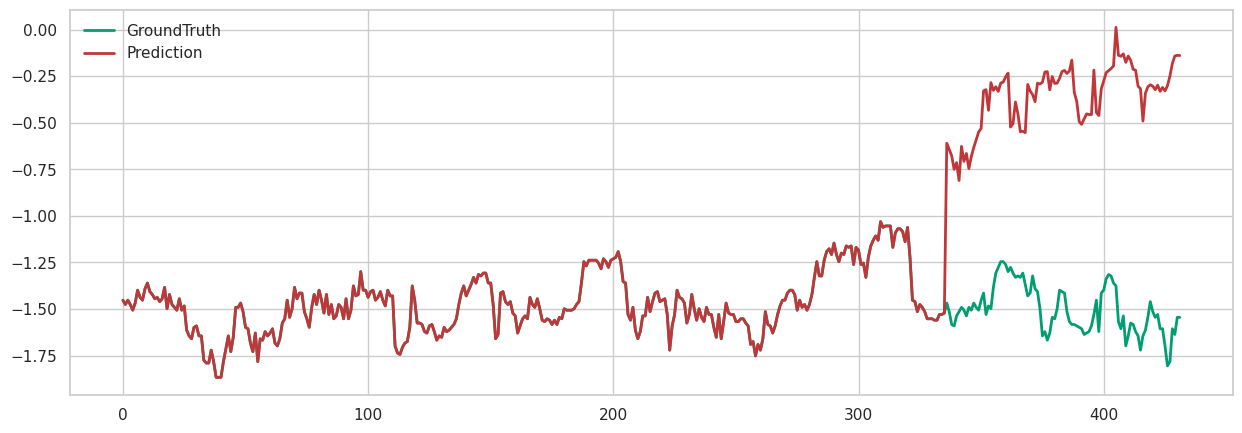

In [44]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

## Trail 2: Informer, Dataset:ETTh1,  Metric: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [15]:
args.pred_len = 192

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTh1_192:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'output_attention': False, 'use_amp': False, 'train_only': True, 'train_epochs': 8, 'batch_size': 32, 'learning_rate': 0.0001, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'test', 'itr': 1, 'model': 'informer', 'checkpoints': './Checkpoints/Informer_checkpoints', 'attn': 'prob', 'd_model': 512, 'n_heads': 16, 'factor': 5, 'dropout': 0.1, 'd_ff': 2048, 'activation': 'gelu', 'mix': True, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'e_layers': 2, 'd_layers': 1, 'seq_len': 336, 'label_len': 48, 'pred_len': 192, 'distil': True, 'embed_type': 1}


### Training

In [16]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8113
val 2689
test 2689
	iters:  100, epoch: 1 | loss: 0.6129329
	speed: 0.2411sec/iter | left time: 464.1277sec
	iters:  200, epoch: 1 | loss: 0.5139742
	speed: 0.2453sec/iter | left time: 447.6303sec
Epoch: 1 cost time: 61.62571406364441
Epoch: 1, Steps: 253 | Train Loss: 0.5470771 Vali Loss: 1.5539607 Test Loss: 1.1818848
>>> Validation loss decreased (inf --> 1.553961).  Saving model ...
Updating learning rate to 0.0001
	iters:  100, epoch: 2 | loss: 0.4529743
	speed: 0.5313sec/iter | left time: 888.2927sec
	iters:  200, epoch: 2 | loss: 0.3623905
	speed: 0.2429sec/iter | left time: 381.8986sec
Epoch: 2 cost time: 61.25640296936035
Epoch: 2, Steps: 253 | Train Loss: 0.4296827 Vali Loss: 1.3936552 Test Loss: 1.1605841
>>> Validation loss decreased (1.553961 --> 1.393655).  Saving model ...
Updating learning rate to 5e-05
	iters:  100, epoch: 3 | loss: 0.2812644
	speed: 0.5354sec/iter | left time: 759.6752sec
	iters:  200, epoch: 3 | loss: 0.2947279
	speed: 0.24

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropou

### Testing

test 2689
test shape: (2688, 192, 7) (2688, 192, 7)
mae:1.0696755647659302, mse:1.5818673372268677, rmse:1.257723093032837, mape:27.896514892578125, mspe:247095.515625
CPU times: user 9.13 s, sys: 344 ms, total: 9.47 s
Wall time: 9.11 s


<Figure size 1500x500 with 0 Axes>

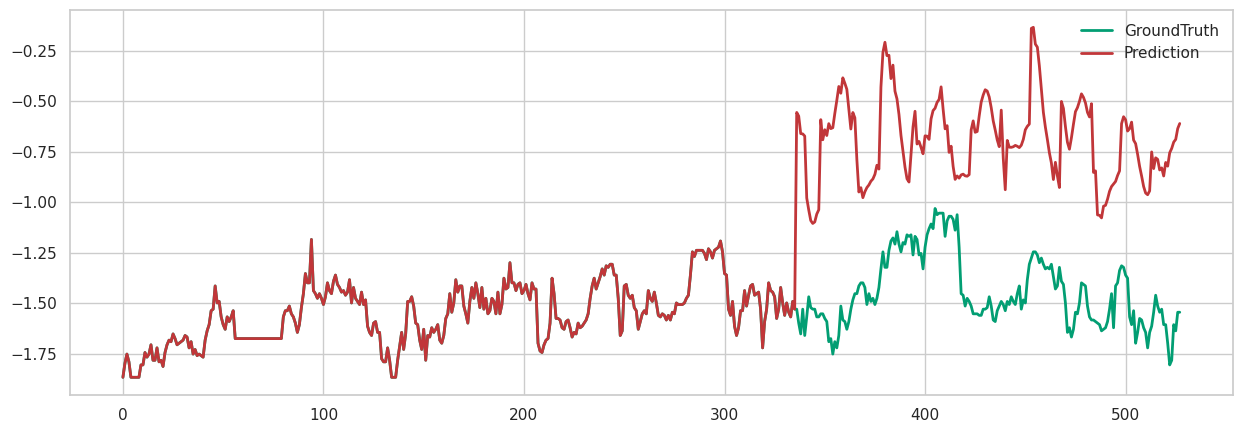

In [17]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 3: Informer, Dataset:ETTh1,  Metric: 336
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [18]:
args.pred_len = 336

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTh1_336:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'output_attention': False, 'use_amp': False, 'train_only': True, 'train_epochs': 8, 'batch_size': 32, 'learning_rate': 0.0001, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'test', 'itr': 1, 'model': 'informer', 'checkpoints': './Checkpoints/Informer_checkpoints', 'attn': 'prob', 'd_model': 512, 'n_heads': 16, 'factor': 5, 'dropout': 0.1, 'd_ff': 2048, 'activation': 'gelu', 'mix': True, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'e_layers': 2, 'd_layers': 1, 'seq_len': 336, 'label_len': 48, 'pred_len': 336, 'distil': True, 'embed_type': 1}


### Training

In [19]:
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 7969
val 2545
test 2545
	iters:  100, epoch: 1 | loss: 0.5465025
	speed: 0.2861sec/iter | left time: 541.6552sec
	iters:  200, epoch: 1 | loss: 0.5073773
	speed: 0.2890sec/iter | left time: 518.1681sec
Epoch: 1 cost time: 71.81089091300964
Epoch: 1, Steps: 249 | Train Loss: 0.5516457 Vali Loss: 1.6725734 Test Loss: 1.2389035
>>> Validation loss decreased (inf --> 1.672573).  Saving model ...
Updating learning rate to 0.0001
	iters:  100, epoch: 2 | loss: 0.4018484
	speed: 0.6123sec/iter | left time: 1006.6613sec
	iters:  200, epoch: 2 | loss: 0.4507703
	speed: 0.2881sec/iter | left time: 444.8672sec
Epoch: 2 cost time: 71.7381272315979
Epoch: 2, Steps: 249 | Train Loss: 0.4594548 Vali Loss: 1.6844134 Test Loss: 1.1816906
EarlyStopping counter: 1 out of 3
Updating learning rate to 5e-05
	iters:  100, epoch: 3 | loss: 0.4878187
	speed: 0.6125sec/iter | left time: 854.3759sec
	iters:  200, epoch: 3 | loss: 0.4192828
	speed: 0.2888sec/iter | left time: 373.9570sec
Epo

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropou

### Testing

test 2545
test shape: (2528, 336, 7) (2528, 336, 7)
mae:0.8257195353507996, mse:1.0836821794509888, rmse:1.0410006046295166, mape:19.9266357421875, mspe:146531.46875


<Figure size 1500x500 with 0 Axes>

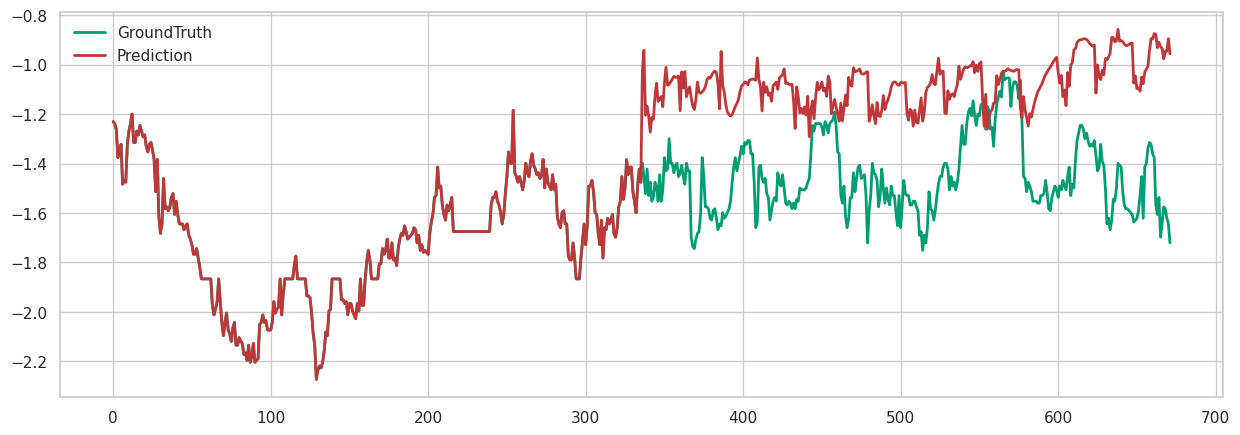

In [20]:
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 4: Informer, Dataset:ETTh1,  Metric: 720
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [21]:
args.pred_len = 720

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTh1_720:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'output_attention': False, 'use_amp': False, 'train_only': True, 'train_epochs': 8, 'batch_size': 32, 'learning_rate': 0.0001, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'test', 'itr': 1, 'model': 'informer', 'checkpoints': './Checkpoints/Informer_checkpoints', 'attn': 'prob', 'd_model': 512, 'n_heads': 16, 'factor': 5, 'dropout': 0.1, 'd_ff': 2048, 'activation': 'gelu', 'mix': True, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'e_layers': 2, 'd_layers': 1, 'seq_len': 336, 'label_len': 48, 'pred_len': 720, 'distil': True, 'embed_type': 1}


### Training

In [22]:
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 7585
val 2161
test 2161
	iters:  100, epoch: 1 | loss: 0.5492048
	speed: 0.4189sec/iter | left time: 752.8191sec
	iters:  200, epoch: 1 | loss: 0.4871001
	speed: 0.4207sec/iter | left time: 713.9540sec
Epoch: 1 cost time: 99.73459768295288
Epoch: 1, Steps: 237 | Train Loss: 0.5564127 Vali Loss: 1.8000246 Test Loss: 1.2032645
>>> Validation loss decreased (inf --> 1.800025).  Saving model ...
Updating learning rate to 0.0001
	iters:  100, epoch: 2 | loss: 0.4635267
	speed: 0.8078sec/iter | left time: 1260.1588sec
	iters:  200, epoch: 2 | loss: 0.4940289
	speed: 0.4205sec/iter | left time: 613.8775sec
Epoch: 2 cost time: 99.59925675392151
Epoch: 2, Steps: 237 | Train Loss: 0.4703322 Vali Loss: 1.7290685 Test Loss: 1.2682279
>>> Validation loss decreased (1.800025 --> 1.729069).  Saving model ...
Updating learning rate to 5e-05
	iters:  100, epoch: 3 | loss: 0.4906681
	speed: 0.8092sec/iter | left time: 1070.5801sec
	iters:  200, epoch: 3 | loss: 0.5308954
	speed: 0.

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropou

### Testing

test 2161
test shape: (2144, 720, 7) (2144, 720, 7)
mae:0.9158769249916077, mse:1.2680299282073975, rmse:1.126068353652954, mape:18.827800750732422, mspe:114878.2578125


<Figure size 1500x500 with 0 Axes>

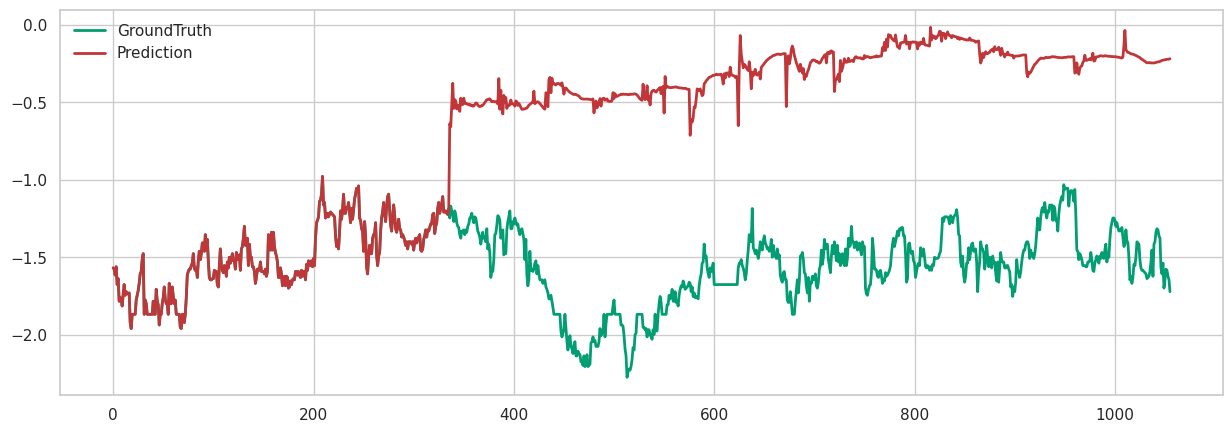

In [23]:
exp.test(setting)
torch.cuda.empty_cache()

---
## Compare Results of `ETTh1`with [Zeng · 2022](https://arxiv.org/abs/2205.13504) Paper

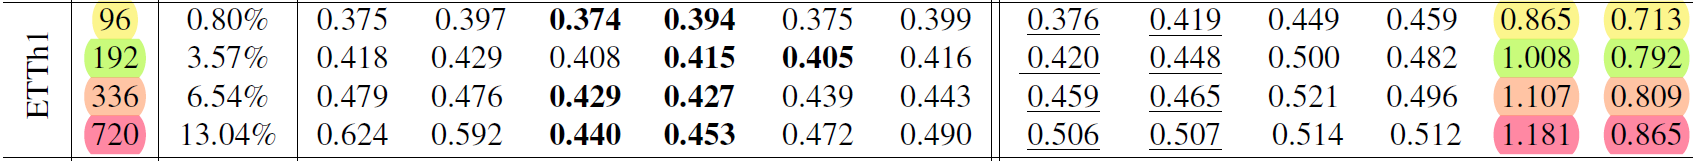

In [24]:
from IPython.display import Image
Image(filename=r"./Images/Informer Results ETTh1.png")

#### **Experiment Results**:
Comaparing my results with the paper resulted highlited in the image above.

| Seq_len | MSE | MAE |
|---|---|---|
| 96 | 1.2901318073272705 | 0.913190722465515 |
| 192 | 1.376012921333313 | 0.982631266117096 |
| 336 | 1.1401041746139526 | 0.8656408190727234 |
| 720 | 1.1068990230560303 | 0.8086273074150085 |


---
# Working on ETTh2 Dataset
---

## Trail 1: Informer, Dataset:ETTh2,  Metric: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [25]:
args.data = 'ETTh2'            # dataset name
args.data_path = 'ETTh2.csv'   # data file
args.pred_len = 96
setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTh2_96:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'output_attention': False, 'use_amp': False, 'train_only': True, 'train_epochs': 8, 'batch_size': 32, 'learning_rate': 0.0001, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'test', 'itr': 1, 'model': 'informer', 'checkpoints': './Checkpoints/Informer_checkpoints', 'attn': 'prob', 'd_model': 512, 'n_heads': 16, 'factor': 5, 'dropout': 0.1, 'd_ff': 2048, 'activation': 'gelu', 'mix': True, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'e_layers': 2, 'd_layers': 1, 'seq_len': 336, 'label_len': 48, 'pred_len': 96, 'distil': True, 'embed_type': 1}


### Training

In [26]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8209
val 2785
test 2785
	iters:  100, epoch: 1 | loss: 0.4846714
	speed: 0.2115sec/iter | left time: 412.1292sec
	iters:  200, epoch: 1 | loss: 0.2962413
	speed: 0.2131sec/iter | left time: 393.9510sec
Epoch: 1 cost time: 54.500816106796265
Epoch: 1, Steps: 256 | Train Loss: 0.3831989 Vali Loss: 1.3994933 Test Loss: 4.6071272
>>> Validation loss decreased (inf --> 1.399493).  Saving model ...
Updating learning rate to 0.0001
	iters:  100, epoch: 2 | loss: 0.3121141
	speed: 0.4787sec/iter | left time: 810.4748sec
	iters:  200, epoch: 2 | loss: 0.1921692
	speed: 0.2131sec/iter | left time: 339.4576sec
Epoch: 2 cost time: 54.583046197891235
Epoch: 2, Steps: 256 | Train Loss: 0.2428884 Vali Loss: 1.4839127 Test Loss: 4.3884878
EarlyStopping counter: 1 out of 3
Updating learning rate to 5e-05
	iters:  100, epoch: 3 | loss: 0.2230772
	speed: 0.4769sec/iter | left time: 685.2851sec
	iters:  200, epoch: 3 | loss: 0.2155060
	speed: 0.2128sec/iter | left time: 284.5298sec
E

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropou

### Testing

test 2785
test shape: (2784, 96, 7) (2784, 96, 7)
mae:1.7496463060379028, mse:4.606810569763184, rmse:2.146348237991333, mape:7.535555362701416, mspe:2580.726318359375
CPU times: user 8.03 s, sys: 354 ms, total: 8.39 s
Wall time: 7.95 s


<Figure size 1500x500 with 0 Axes>

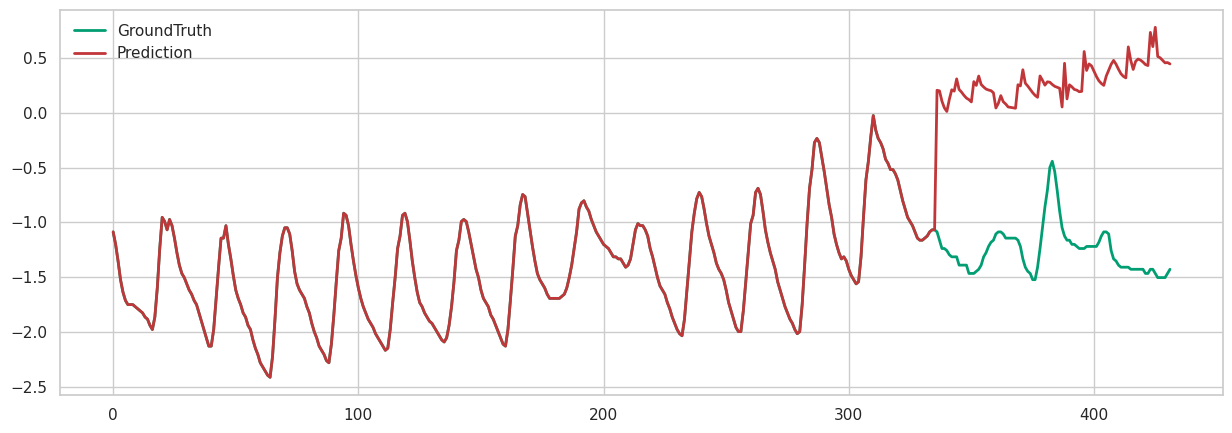

In [27]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 2: Informer, Dataset:ETTh2,  Metric: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [28]:
args.pred_len = 192

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTh2_192:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'output_attention': False, 'use_amp': False, 'train_only': True, 'train_epochs': 8, 'batch_size': 32, 'learning_rate': 0.0001, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'test', 'itr': 1, 'model': 'informer', 'checkpoints': './Checkpoints/Informer_checkpoints', 'attn': 'prob', 'd_model': 512, 'n_heads': 16, 'factor': 5, 'dropout': 0.1, 'd_ff': 2048, 'activation': 'gelu', 'mix': True, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'e_layers': 2, 'd_layers': 1, 'seq_len': 336, 'label_len': 48, 'pred_len': 192, 'distil': True, 'embed_type': 1}


### Training

In [29]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8113
val 2689
test 2689
	iters:  100, epoch: 1 | loss: 0.3655926
	speed: 0.2406sec/iter | left time: 463.0879sec
	iters:  200, epoch: 1 | loss: 0.3468833
	speed: 0.2427sec/iter | left time: 442.9244sec
Epoch: 1 cost time: 61.34560179710388
Epoch: 1, Steps: 253 | Train Loss: 0.4038022 Vali Loss: 1.4232688 Test Loss: 5.6450124
>>> Validation loss decreased (inf --> 1.423269).  Saving model ...
Updating learning rate to 0.0001
	iters:  100, epoch: 2 | loss: 0.2483778
	speed: 0.5338sec/iter | left time: 892.5872sec
	iters:  200, epoch: 2 | loss: 0.3023358
	speed: 0.2428sec/iter | left time: 381.6981sec
Epoch: 2 cost time: 61.42250967025757
Epoch: 2, Steps: 253 | Train Loss: 0.2662796 Vali Loss: 1.3757441 Test Loss: 6.7228866
>>> Validation loss decreased (1.423269 --> 1.375744).  Saving model ...
Updating learning rate to 5e-05
	iters:  100, epoch: 3 | loss: 0.2479587
	speed: 0.5342sec/iter | left time: 758.0155sec
	iters:  200, epoch: 3 | loss: 0.2222786
	speed: 0.24

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropou

### Testing

test 2689
test shape: (2688, 192, 7) (2688, 192, 7)
mae:2.1953821182250977, mse:6.722298622131348, rmse:2.5927395820617676, mape:10.005045890808105, mspe:6133.77099609375
CPU times: user 8.92 s, sys: 358 ms, total: 9.28 s
Wall time: 8.86 s


<Figure size 1500x500 with 0 Axes>

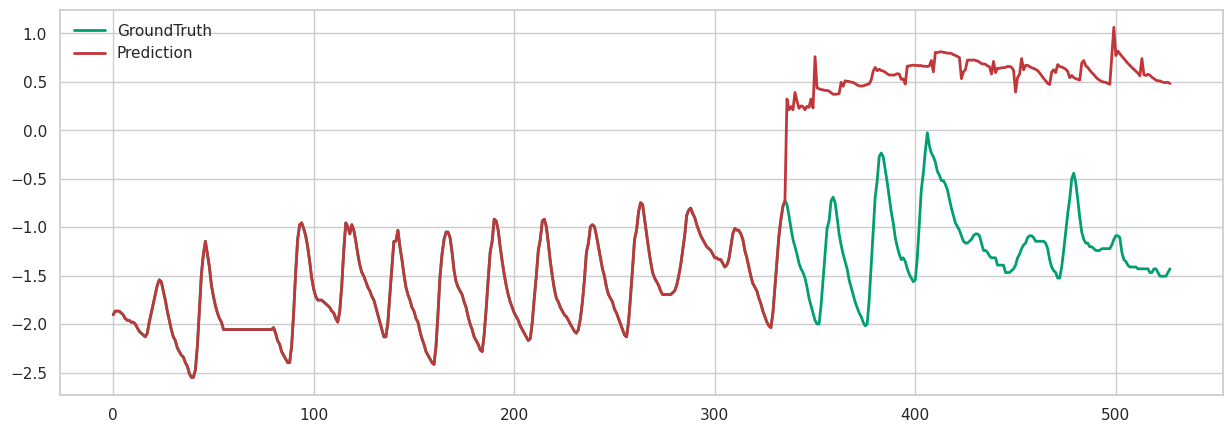

In [30]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 3: Informer, Dataset:ETTh2,  Metric: 336
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [31]:
args.pred_len = 336

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTh2_336:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'output_attention': False, 'use_amp': False, 'train_only': True, 'train_epochs': 8, 'batch_size': 32, 'learning_rate': 0.0001, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'test', 'itr': 1, 'model': 'informer', 'checkpoints': './Checkpoints/Informer_checkpoints', 'attn': 'prob', 'd_model': 512, 'n_heads': 16, 'factor': 5, 'dropout': 0.1, 'd_ff': 2048, 'activation': 'gelu', 'mix': True, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'e_layers': 2, 'd_layers': 1, 'seq_len': 336, 'label_len': 48, 'pred_len': 336, 'distil': True, 'embed_type': 1}


### Training

In [32]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 7969
val 2545
test 2545
	iters:  100, epoch: 1 | loss: 0.4418853
	speed: 0.2860sec/iter | left time: 541.4227sec
	iters:  200, epoch: 1 | loss: 0.4032049
	speed: 0.2886sec/iter | left time: 517.5103sec
Epoch: 1 cost time: 71.76184749603271
Epoch: 1, Steps: 249 | Train Loss: 0.4332847 Vali Loss: 0.8451248 Test Loss: 2.0611825
>>> Validation loss decreased (inf --> 0.845125).  Saving model ...
Updating learning rate to 0.0001
	iters:  100, epoch: 2 | loss: 0.2671722
	speed: 0.6126sec/iter | left time: 1007.0385sec
	iters:  200, epoch: 2 | loss: 0.2733236
	speed: 0.2882sec/iter | left time: 445.0450sec
Epoch: 2 cost time: 71.76291251182556
Epoch: 2, Steps: 249 | Train Loss: 0.2840990 Vali Loss: 0.9870342 Test Loss: 2.6021247
EarlyStopping counter: 1 out of 3
Updating learning rate to 5e-05
	iters:  100, epoch: 3 | loss: 0.2574418
	speed: 0.6115sec/iter | left time: 853.0616sec
	iters:  200, epoch: 3 | loss: 0.2116321
	speed: 0.2883sec/iter | left time: 373.3400sec
Ep

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropou

### Testing

test 2545
test shape: (2528, 336, 7) (2528, 336, 7)
mae:1.1626453399658203, mse:2.0620219707489014, rmse:1.4359742403030396, mape:7.4195332527160645, mspe:5624.47412109375


<Figure size 1500x500 with 0 Axes>

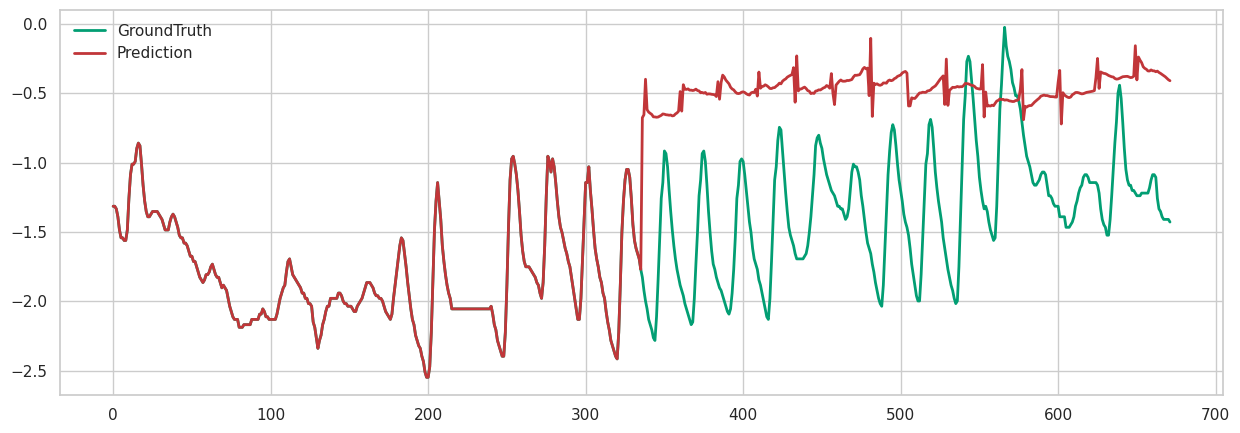

In [33]:
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 4: Informer, Dataset:ETTh2,  Metric: 720
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [34]:
args.pred_len = 720

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTh2_720:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'output_attention': False, 'use_amp': False, 'train_only': True, 'train_epochs': 8, 'batch_size': 32, 'learning_rate': 0.0001, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'test', 'itr': 1, 'model': 'informer', 'checkpoints': './Checkpoints/Informer_checkpoints', 'attn': 'prob', 'd_model': 512, 'n_heads': 16, 'factor': 5, 'dropout': 0.1, 'd_ff': 2048, 'activation': 'gelu', 'mix': True, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'e_layers': 2, 'd_layers': 1, 'seq_len': 336, 'label_len': 48, 'pred_len': 720, 'distil': True, 'embed_type': 1}


### Training

In [35]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 7585
val 2161
test 2161
	iters:  100, epoch: 1 | loss: 0.4618321
	speed: 0.4186sec/iter | left time: 752.2793sec
	iters:  200, epoch: 1 | loss: 0.3185426
	speed: 0.4223sec/iter | left time: 716.6239sec
Epoch: 1 cost time: 99.91623187065125
Epoch: 1, Steps: 237 | Train Loss: 0.4814922 Vali Loss: 1.1806687 Test Loss: 3.2675161
>>> Validation loss decreased (inf --> 1.180669).  Saving model ...
Updating learning rate to 0.0001
	iters:  100, epoch: 2 | loss: 0.2806873
	speed: 0.8094sec/iter | left time: 1262.6963sec
	iters:  200, epoch: 2 | loss: 0.2669512
	speed: 0.4213sec/iter | left time: 615.0363sec
Epoch: 2 cost time: 99.83100438117981
Epoch: 2, Steps: 237 | Train Loss: 0.3083193 Vali Loss: 1.2354398 Test Loss: 2.3605449
EarlyStopping counter: 1 out of 3
Updating learning rate to 5e-05
	iters:  100, epoch: 3 | loss: 0.2539977
	speed: 0.8083sec/iter | left time: 1069.4035sec
	iters:  200, epoch: 3 | loss: 0.2108482
	speed: 0.4211sec/iter | left time: 514.9817sec
E

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropou

### Testing

test 2161
test shape: (2144, 720, 7) (2144, 720, 7)
mae:1.5665271282196045, mse:3.2670657634735107, rmse:1.8075026273727417, mape:15.660711288452148, mspe:14393.2197265625
CPU times: user 12.5 s, sys: 513 ms, total: 13 s
Wall time: 12.5 s


<Figure size 1500x500 with 0 Axes>

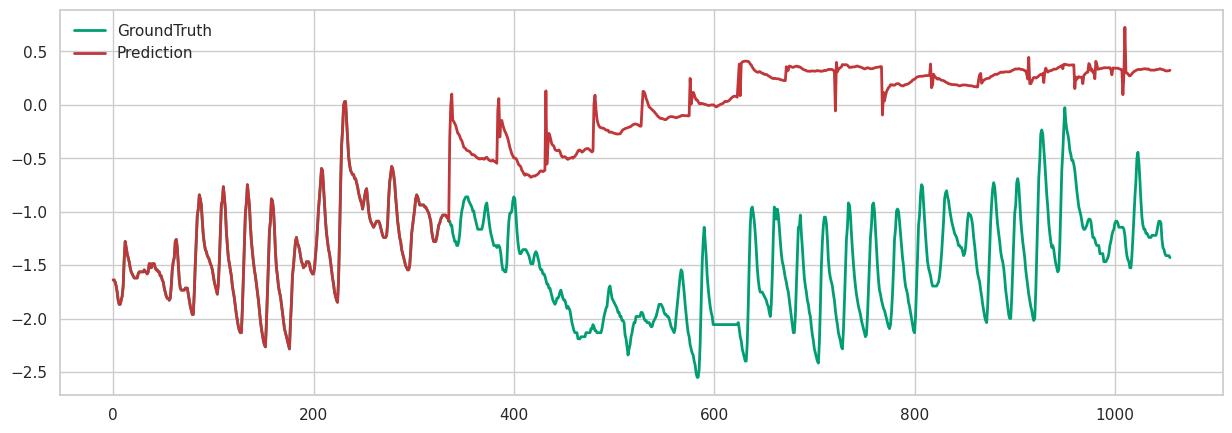

In [36]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

---
## Compare Results of `ETTh2`with [Zeng · 2022](https://arxiv.org/abs/2205.13504) Paper

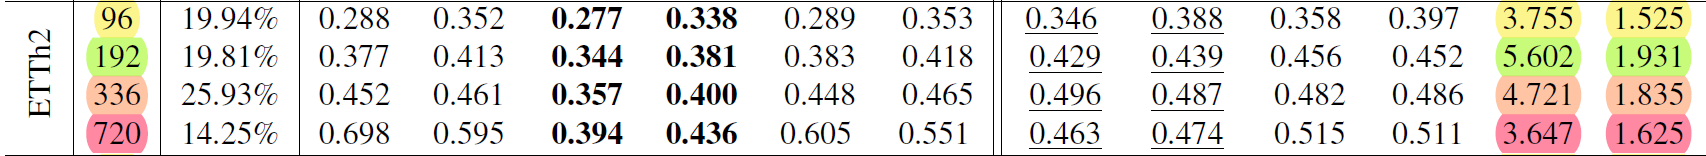

In [37]:
from IPython.display import Image
Image(filename=r"./Images/Informer Results ETTh2.png")

#### **Experiment Results**:
Comaparing my results with the paper resulted highlited in the image above.

| Seq_len | MSE | MAE |
|---|---|---|
| 96 | 2.4837021827697754 | 1.15531587600708 |
| 192 | 3.5453412532806396 | 1.6633073091506958 |
| 336 | 2.984318494796753 | 1.3787071704864502 |
| 720 | 3.013077735900879 | 1.4968270063400269 |

---
# Working on ETTm1 Dataset
---

## Trail 1: Informer, Dataset:ETTm1,  Metric: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [38]:
args.data = 'ETTm1'            # dataset name
args.data_path = 'ETTm1.csv'   # data file
args.pred_len = 96

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTm1_96:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'output_attention': False, 'use_amp': False, 'train_only': True, 'train_epochs': 8, 'batch_size': 32, 'learning_rate': 0.0001, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'test', 'itr': 1, 'model': 'informer', 'checkpoints': './Checkpoints/Informer_checkpoints', 'attn': 'prob', 'd_model': 512, 'n_heads': 16, 'factor': 5, 'dropout': 0.1, 'd_ff': 2048, 'activation': 'gelu', 'mix': True, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'e_layers': 2, 'd_layers': 1, 'seq_len': 336, 'label_len': 48, 'pred_len': 96, 'distil': True, 'embed_type': 1}


### Training

In [39]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34129
val 11425
test 11425
	iters:  100, epoch: 1 | loss: 0.4737447
	speed: 0.2115sec/iter | left time: 1782.6368sec
	iters:  200, epoch: 1 | loss: 0.3066774
	speed: 0.2132sec/iter | left time: 1775.3747sec
	iters:  300, epoch: 1 | loss: 0.2838545
	speed: 0.2134sec/iter | left time: 1755.6987sec
	iters:  400, epoch: 1 | loss: 0.2859619
	speed: 0.2129sec/iter | left time: 1730.8550sec
	iters:  500, epoch: 1 | loss: 0.2040155
	speed: 0.2129sec/iter | left time: 1709.4207sec
	iters:  600, epoch: 1 | loss: 0.2006548
	speed: 0.2126sec/iter | left time: 1685.9495sec
	iters:  700, epoch: 1 | loss: 0.2721496
	speed: 0.2128sec/iter | left time: 1665.9984sec
	iters:  800, epoch: 1 | loss: 0.2724552
	speed: 0.2129sec/iter | left time: 1645.1584sec
	iters:  900, epoch: 1 | loss: 0.1886430
	speed: 0.2131sec/iter | left time: 1625.8798sec
	iters: 1000, epoch: 1 | loss: 0.1670309
	speed: 0.2128sec/iter | left time: 1602.4622sec
Epoch: 1 cost time: 226.98640155792236
Epoch: 1, St

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropou

### Testing

test 11425
test shape: (11424, 96, 7) (11424, 96, 7)
mae:0.5072861909866333, mse:0.5105550289154053, rmse:0.7145313620567322, mape:2.406381368637085, mspe:384.1308288574219


<Figure size 1500x500 with 0 Axes>

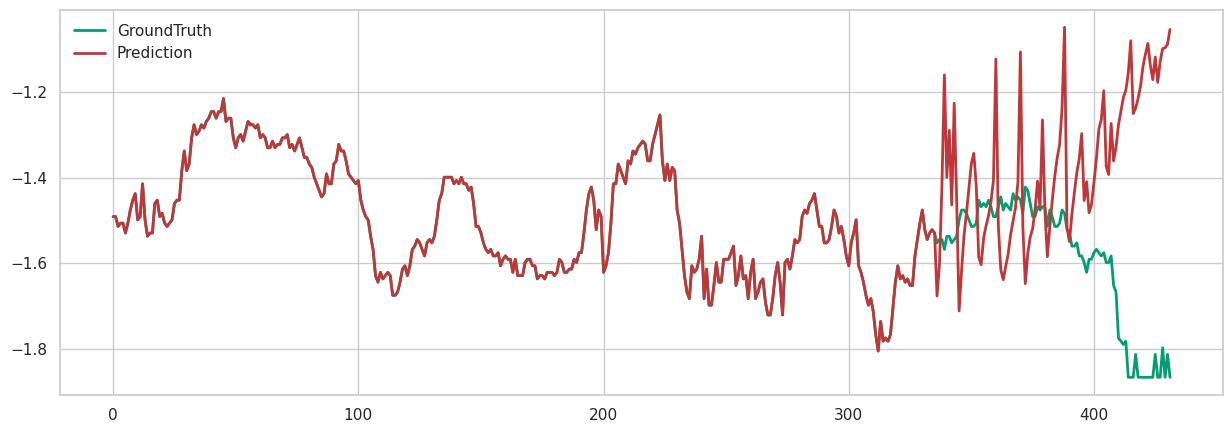

In [40]:
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 2: Informer, Dataset:ETTm1,  Metric: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [41]:
args.pred_len = 192

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTm1_192:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'output_attention': False, 'use_amp': False, 'train_only': True, 'train_epochs': 8, 'batch_size': 32, 'learning_rate': 0.0001, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'test', 'itr': 1, 'model': 'informer', 'checkpoints': './Checkpoints/Informer_checkpoints', 'attn': 'prob', 'd_model': 512, 'n_heads': 16, 'factor': 5, 'dropout': 0.1, 'd_ff': 2048, 'activation': 'gelu', 'mix': True, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'e_layers': 2, 'd_layers': 1, 'seq_len': 336, 'label_len': 48, 'pred_len': 192, 'distil': True, 'embed_type': 1}


### Training

In [42]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34033
val 11329
test 11329
	iters:  100, epoch: 1 | loss: 0.4264556
	speed: 0.2409sec/iter | left time: 2024.8695sec
	iters:  200, epoch: 1 | loss: 0.3244893
	speed: 0.2429sec/iter | left time: 2017.2858sec
	iters:  300, epoch: 1 | loss: 0.3098250
	speed: 0.2431sec/iter | left time: 1994.7496sec
	iters:  400, epoch: 1 | loss: 0.2534195
	speed: 0.2431sec/iter | left time: 1970.4232sec
	iters:  500, epoch: 1 | loss: 0.2498918
	speed: 0.2431sec/iter | left time: 1945.6910sec
	iters:  600, epoch: 1 | loss: 0.2727538
	speed: 0.2423sec/iter | left time: 1915.0257sec
	iters:  700, epoch: 1 | loss: 0.2552404
	speed: 0.2427sec/iter | left time: 1893.9145sec
	iters:  800, epoch: 1 | loss: 0.2500647
	speed: 0.2420sec/iter | left time: 1864.6754sec
	iters:  900, epoch: 1 | loss: 0.2306976
	speed: 0.2422sec/iter | left time: 1841.6709sec
	iters: 1000, epoch: 1 | loss: 0.1936015
	speed: 0.2425sec/iter | left time: 1819.7338sec
Epoch: 1 cost time: 257.8501625061035
Epoch: 1, Ste

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropou

### Testing

test 11329
test shape: (11328, 192, 7) (11328, 192, 7)
mae:0.6627843379974365, mse:0.8066930770874023, rmse:0.8981609344482422, mape:3.299241065979004, mspe:755.5782470703125
CPU times: user 34.9 s, sys: 530 ms, total: 35.4 s
Wall time: 35.1 s


<Figure size 1500x500 with 0 Axes>

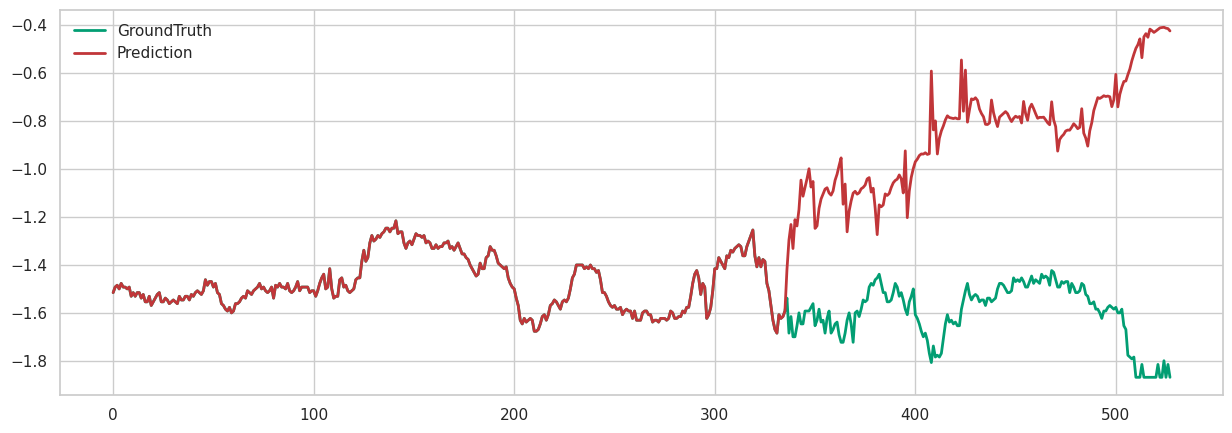

In [43]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 3: Informer, Dataset:ETTm1,  Metric: 336
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [44]:
args.pred_len = 336

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTm1_336:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'output_attention': False, 'use_amp': False, 'train_only': True, 'train_epochs': 8, 'batch_size': 32, 'learning_rate': 0.0001, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'test', 'itr': 1, 'model': 'informer', 'checkpoints': './Checkpoints/Informer_checkpoints', 'attn': 'prob', 'd_model': 512, 'n_heads': 16, 'factor': 5, 'dropout': 0.1, 'd_ff': 2048, 'activation': 'gelu', 'mix': True, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'e_layers': 2, 'd_layers': 1, 'seq_len': 336, 'label_len': 48, 'pred_len': 336, 'distil': True, 'embed_type': 1}


### Training

In [45]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 33889
val 11185
test 11185
	iters:  100, epoch: 1 | loss: 0.4866304
	speed: 0.2862sec/iter | left time: 2395.9814sec
	iters:  200, epoch: 1 | loss: 0.3914897
	speed: 0.2889sec/iter | left time: 2390.1658sec
	iters:  300, epoch: 1 | loss: 0.3525128
	speed: 0.2885sec/iter | left time: 2357.9475sec
	iters:  400, epoch: 1 | loss: 0.2755924
	speed: 0.2885sec/iter | left time: 2328.7434sec
	iters:  500, epoch: 1 | loss: 0.2957508
	speed: 0.2883sec/iter | left time: 2298.7519sec
	iters:  600, epoch: 1 | loss: 0.2606158
	speed: 0.2884sec/iter | left time: 2270.4892sec
	iters:  700, epoch: 1 | loss: 0.2451059
	speed: 0.2882sec/iter | left time: 2240.4849sec
	iters:  800, epoch: 1 | loss: 0.2387625
	speed: 0.2882sec/iter | left time: 2211.5294sec
	iters:  900, epoch: 1 | loss: 0.2350689
	speed: 0.2884sec/iter | left time: 2184.1492sec
	iters: 1000, epoch: 1 | loss: 0.2397922
	speed: 0.2881sec/iter | left time: 2152.8820sec
Epoch: 1 cost time: 305.3301510810852
Epoch: 1, Ste

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropou

### Testing

test 11185
test shape: (11168, 336, 7) (11168, 336, 7)
mae:0.7364923357963562, mse:0.867789626121521, rmse:0.9315522909164429, mape:3.477902412414551, mspe:560.9458618164062
CPU times: user 41.2 s, sys: 750 ms, total: 41.9 s
Wall time: 41.6 s


<Figure size 1500x500 with 0 Axes>

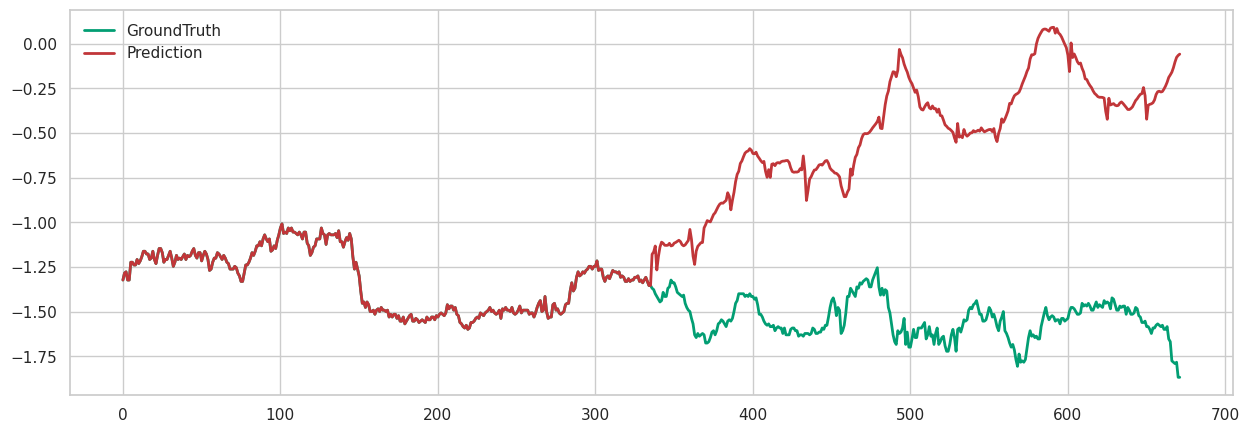

In [46]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 4: Informer, Dataset:ETTm1,  Metric: 720
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [47]:
args.pred_len = 720

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTm1_720:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'output_attention': False, 'use_amp': False, 'train_only': True, 'train_epochs': 8, 'batch_size': 32, 'learning_rate': 0.0001, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'test', 'itr': 1, 'model': 'informer', 'checkpoints': './Checkpoints/Informer_checkpoints', 'attn': 'prob', 'd_model': 512, 'n_heads': 16, 'factor': 5, 'dropout': 0.1, 'd_ff': 2048, 'activation': 'gelu', 'mix': True, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'e_layers': 2, 'd_layers': 1, 'seq_len': 336, 'label_len': 48, 'pred_len': 720, 'distil': True, 'embed_type': 1}


### Training

In [48]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 33505
val 10801
test 10801
	iters:  100, epoch: 1 | loss: 0.5218711
	speed: 0.4186sec/iter | left time: 3464.4700sec
	iters:  200, epoch: 1 | loss: 0.4710676
	speed: 0.4209sec/iter | left time: 3441.8013sec
	iters:  300, epoch: 1 | loss: 0.3564426
	speed: 0.4202sec/iter | left time: 3394.0256sec
	iters:  400, epoch: 1 | loss: 0.3257685
	speed: 0.4204sec/iter | left time: 3353.6413sec
	iters:  500, epoch: 1 | loss: 0.3582006
	speed: 0.4215sec/iter | left time: 3319.8433sec
	iters:  600, epoch: 1 | loss: 0.2842635
	speed: 0.4219sec/iter | left time: 3281.0976sec
	iters:  700, epoch: 1 | loss: 0.2964671
	speed: 0.4216sec/iter | left time: 3236.6857sec
	iters:  800, epoch: 1 | loss: 0.2866997
	speed: 0.4209sec/iter | left time: 3189.2594sec
	iters:  900, epoch: 1 | loss: 0.2625542
	speed: 0.4212sec/iter | left time: 3149.2463sec
	iters: 1000, epoch: 1 | loss: 0.2599604
	speed: 0.4210sec/iter | left time: 3105.5365sec
Epoch: 1 cost time: 440.84021759033203
Epoch: 1, St

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropou

### Testing

test 10801
test shape: (10784, 720, 7) (10784, 720, 7)
mae:0.7687328457832336, mse:0.9479221701622009, rmse:0.9736129641532898, mape:3.2668585777282715, mspe:620.50439453125
CPU times: user 59.4 s, sys: 1.18 s, total: 1min
Wall time: 1min


<Figure size 1500x500 with 0 Axes>

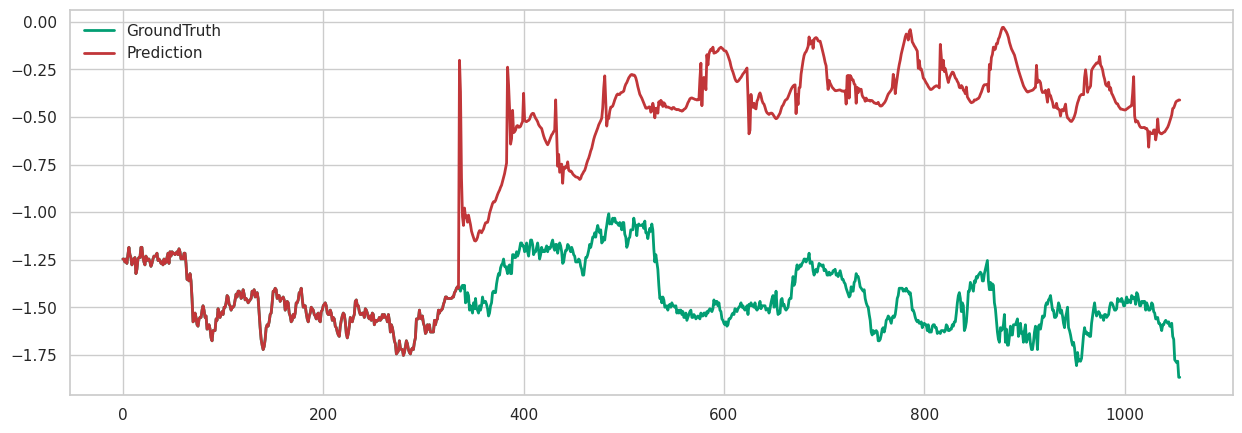

In [49]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

---
## Compare Results of `ETTm1`with [Zeng · 2022](https://arxiv.org/abs/2205.13504) Paper

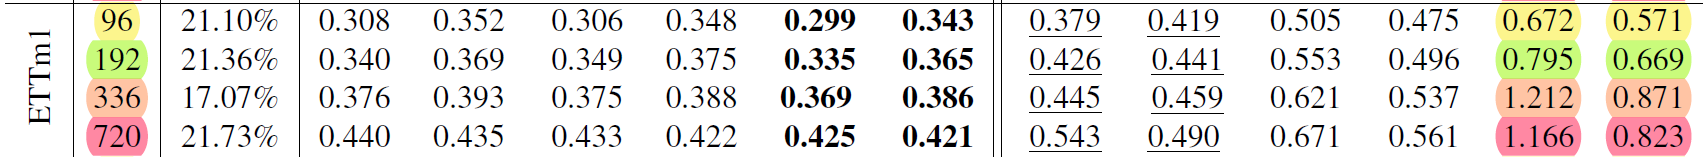

In [50]:
from IPython.display import Image
Image(filename=r"./Images/Informer Results ETTm1.png")

#### **Experiment Results**:
Comaparing my results with the paper resulted highlited in the image above.

| Seq_len | MSE | MAE |
|---|---|---|
| 96 | 1.3374640941619873 | 0.9618014693260193 |
| 192 | 1.2347673177719116 | 0.8905289173126221 |
| 336 | 1.1492547988891602 | 0.8315280079841614 |
| 720 | 1.132256031036377 | 0.8511157035827637 |

---
# Working on ETTm2 Dataset
---

## Trail 1: Informer, Dataset:ETTm2,  Metric: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [51]:
args.data = 'ETTm2'            # dataset name
args.data_path = 'ETTm2.csv'   # data file
args.seq_len = 96

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTm2_720:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'output_attention': False, 'use_amp': False, 'train_only': True, 'train_epochs': 8, 'batch_size': 32, 'learning_rate': 0.0001, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'test', 'itr': 1, 'model': 'informer', 'checkpoints': './Checkpoints/Informer_checkpoints', 'attn': 'prob', 'd_model': 512, 'n_heads': 16, 'factor': 5, 'dropout': 0.1, 'd_ff': 2048, 'activation': 'gelu', 'mix': True, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'e_layers': 2, 'd_layers': 1, 'seq_len': 96, 'label_len': 48, 'pred_len': 720, 'distil': True, 'embed_type': 1}


### Training

In [52]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 33745
val 10801
test 10801
	iters:  100, epoch: 1 | loss: 0.3632017
	speed: 0.2920sec/iter | left time: 2432.9258sec
	iters:  200, epoch: 1 | loss: 0.3993266
	speed: 0.2943sec/iter | left time: 2423.1389sec
	iters:  300, epoch: 1 | loss: 0.2593893
	speed: 0.2934sec/iter | left time: 2386.4828sec
	iters:  400, epoch: 1 | loss: 0.4376884
	speed: 0.2933sec/iter | left time: 2355.8077sec
	iters:  500, epoch: 1 | loss: 0.2881122
	speed: 0.2933sec/iter | left time: 2326.9328sec
	iters:  600, epoch: 1 | loss: 0.2222212
	speed: 0.2937sec/iter | left time: 2300.8341sec
	iters:  700, epoch: 1 | loss: 0.1864104
	speed: 0.2935sec/iter | left time: 2269.4456sec
	iters:  800, epoch: 1 | loss: 0.2801999
	speed: 0.2937sec/iter | left time: 2241.8141sec
	iters:  900, epoch: 1 | loss: 0.2805239
	speed: 0.2939sec/iter | left time: 2214.0323sec
	iters: 1000, epoch: 1 | loss: 0.1925872
	speed: 0.2938sec/iter | left time: 2184.0516sec
Epoch: 1 cost time: 309.5315067768097
Epoch: 1, Ste

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropou

### Testing

test 10801
test shape: (10784, 720, 7) (10784, 720, 7)
mae:1.6127536296844482, mse:4.646228313446045, rmse:2.1555111408233643, mape:8.000442504882812, mspe:11837.767578125
CPU times: user 42.6 s, sys: 1.11 s, total: 43.7 s
Wall time: 43.4 s


<Figure size 1500x500 with 0 Axes>

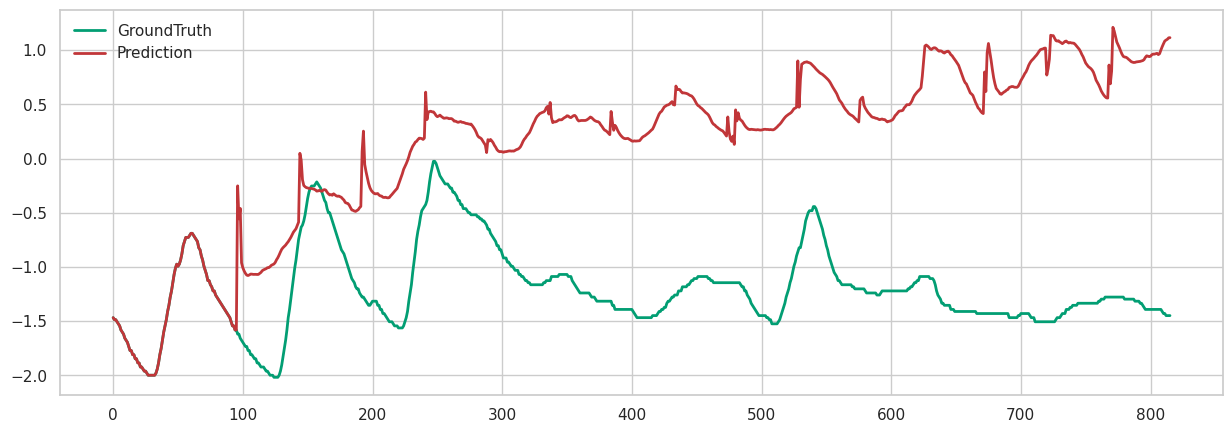

In [53]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 2: Informer, Dataset:ETTm2,  Metric: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [54]:
args.pred_len = 192

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTm2_192:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'output_attention': False, 'use_amp': False, 'train_only': True, 'train_epochs': 8, 'batch_size': 32, 'learning_rate': 0.0001, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'test', 'itr': 1, 'model': 'informer', 'checkpoints': './Checkpoints/Informer_checkpoints', 'attn': 'prob', 'd_model': 512, 'n_heads': 16, 'factor': 5, 'dropout': 0.1, 'd_ff': 2048, 'activation': 'gelu', 'mix': True, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'e_layers': 2, 'd_layers': 1, 'seq_len': 96, 'label_len': 48, 'pred_len': 192, 'distil': True, 'embed_type': 1}


### Training

In [55]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34273
val 11329
test 11329
	iters:  100, epoch: 1 | loss: 0.3516449
	speed: 0.1290sec/iter | left time: 1092.2272sec
	iters:  200, epoch: 1 | loss: 0.3051135
	speed: 0.1303sec/iter | left time: 1090.1650sec
	iters:  300, epoch: 1 | loss: 0.2156419
	speed: 0.1301sec/iter | left time: 1075.8260sec
	iters:  400, epoch: 1 | loss: 0.2333679
	speed: 0.1301sec/iter | left time: 1062.7361sec
	iters:  500, epoch: 1 | loss: 0.1681421
	speed: 0.1297sec/iter | left time: 1046.8763sec
	iters:  600, epoch: 1 | loss: 0.1996991
	speed: 0.1297sec/iter | left time: 1033.2774sec
	iters:  700, epoch: 1 | loss: 0.1590578
	speed: 0.1297sec/iter | left time: 1020.7032sec
	iters:  800, epoch: 1 | loss: 0.2503700
	speed: 0.1293sec/iter | left time: 1004.9018sec
	iters:  900, epoch: 1 | loss: 0.1382508
	speed: 0.1295sec/iter | left time: 993.3735sec
	iters: 1000, epoch: 1 | loss: 0.2327214
	speed: 0.1296sec/iter | left time: 981.0286sec
Epoch: 1 cost time: 138.9717457294464
Epoch: 1, Steps

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropou

### Testing

test 11329
test shape: (11328, 192, 7) (11328, 192, 7)
mae:0.7399733662605286, mse:0.9397547245025635, rmse:0.9694094657897949, mape:6.109927654266357, mspe:6613.5654296875
CPU times: user 18.7 s, sys: 548 ms, total: 19.2 s
Wall time: 18.8 s


<Figure size 1500x500 with 0 Axes>

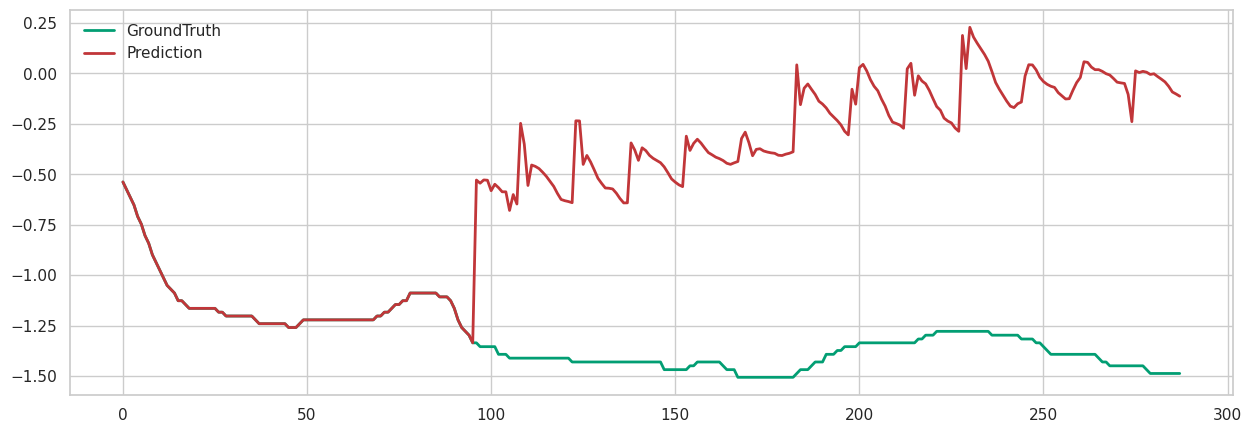

In [56]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 3: Informer, Dataset:ETTm2,  Metric: 336
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [57]:
args.pred_len = 336

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTm2_336:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'output_attention': False, 'use_amp': False, 'train_only': True, 'train_epochs': 8, 'batch_size': 32, 'learning_rate': 0.0001, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'test', 'itr': 1, 'model': 'informer', 'checkpoints': './Checkpoints/Informer_checkpoints', 'attn': 'prob', 'd_model': 512, 'n_heads': 16, 'factor': 5, 'dropout': 0.1, 'd_ff': 2048, 'activation': 'gelu', 'mix': True, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'e_layers': 2, 'd_layers': 1, 'seq_len': 96, 'label_len': 48, 'pred_len': 336, 'distil': True, 'embed_type': 1}


### Training

In [58]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34129
val 11185
test 11185
	iters:  100, epoch: 1 | loss: 0.2748954
	speed: 0.1720sec/iter | left time: 1449.7769sec
	iters:  200, epoch: 1 | loss: 0.3193426
	speed: 0.1727sec/iter | left time: 1438.3800sec
	iters:  300, epoch: 1 | loss: 0.2207173
	speed: 0.1724sec/iter | left time: 1418.5132sec
	iters:  400, epoch: 1 | loss: 0.2794754
	speed: 0.1723sec/iter | left time: 1400.5429sec
	iters:  500, epoch: 1 | loss: 0.2325080
	speed: 0.1724sec/iter | left time: 1383.9848sec
	iters:  600, epoch: 1 | loss: 0.2964483
	speed: 0.1724sec/iter | left time: 1366.7655sec
	iters:  700, epoch: 1 | loss: 0.1879057
	speed: 0.1722sec/iter | left time: 1347.7810sec
	iters:  800, epoch: 1 | loss: 0.1668731
	speed: 0.1723sec/iter | left time: 1331.4847sec
	iters:  900, epoch: 1 | loss: 0.1838005
	speed: 0.1724sec/iter | left time: 1315.2047sec
	iters: 1000, epoch: 1 | loss: 0.2965772
	speed: 0.1722sec/iter | left time: 1296.8579sec
Epoch: 1 cost time: 183.79687881469727
Epoch: 1, St

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropou

### Testing

test 11185
test shape: (11168, 336, 7) (11168, 336, 7)
mae:0.9547346234321594, mse:1.5055575370788574, rmse:1.2270116806030273, mape:9.97520637512207, mspe:21025.474609375
CPU times: user 24.8 s, sys: 1.12 s, total: 25.9 s
Wall time: 25.5 s


<Figure size 1500x500 with 0 Axes>

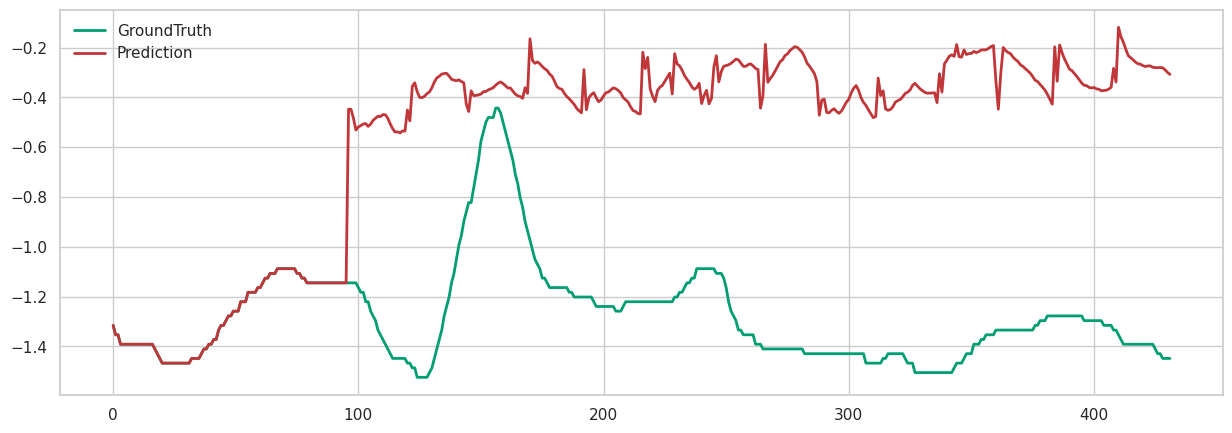

In [59]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

---
## Trail 4: Informer, Dataset:ETTm2,  Metric: 720
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [60]:
args.pred_len = 720

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of informer_train_on_ETTm2_720:

{'use_multi_gpu': False, 'num_workers': 0, 'use_gpu': True, 'gpu': 0, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'embed': 'timeF', 'padding': 0, 'output_attention': False, 'use_amp': False, 'train_only': True, 'train_epochs': 8, 'batch_size': 32, 'learning_rate': 0.0001, 'lradj': 'type1', 'loss': 'mse', 'patience': 3, 'des': 'test', 'itr': 1, 'model': 'informer', 'checkpoints': './Checkpoints/Informer_checkpoints', 'attn': 'prob', 'd_model': 512, 'n_heads': 16, 'factor': 5, 'dropout': 0.1, 'd_ff': 2048, 'activation': 'gelu', 'mix': True, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'e_layers': 2, 'd_layers': 1, 'seq_len': 96, 'label_len': 48, 'pred_len': 720, 'distil': True, 'embed_type': 1}


### Training

In [61]:
%%time
Exp = Exp_Informer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 33745
val 10801
test 10801
	iters:  100, epoch: 1 | loss: 0.4457756
	speed: 0.2927sec/iter | left time: 2438.9729sec
	iters:  200, epoch: 1 | loss: 0.3234092
	speed: 0.2945sec/iter | left time: 2424.3863sec
	iters:  300, epoch: 1 | loss: 0.4607202
	speed: 0.2935sec/iter | left time: 2387.3900sec
	iters:  400, epoch: 1 | loss: 0.2095201
	speed: 0.2930sec/iter | left time: 2354.0054sec
	iters:  500, epoch: 1 | loss: 0.3231887
	speed: 0.2933sec/iter | left time: 2326.6866sec
	iters:  600, epoch: 1 | loss: 0.2470747
	speed: 0.2935sec/iter | left time: 2299.1682sec
	iters:  700, epoch: 1 | loss: 0.3464561
	speed: 0.2935sec/iter | left time: 2269.6747sec
	iters:  800, epoch: 1 | loss: 0.2763034
	speed: 0.2935sec/iter | left time: 2240.1258sec
	iters:  900, epoch: 1 | loss: 0.3136699
	speed: 0.2935sec/iter | left time: 2210.7418sec
	iters: 1000, epoch: 1 | loss: 0.1884991
	speed: 0.2935sec/iter | left time: 2181.2147sec
Epoch: 1 cost time: 309.4812982082367
Epoch: 1, Ste

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropou

### Testing

test 10801
test shape: (10784, 720, 7) (10784, 720, 7)
mae:1.444502830505371, mse:3.7713623046875, rmse:1.9419995546340942, mape:6.548584461212158, mspe:7806.98046875
CPU times: user 42.4 s, sys: 2.29 s, total: 44.6 s
Wall time: 44.8 s


<Figure size 1500x500 with 0 Axes>

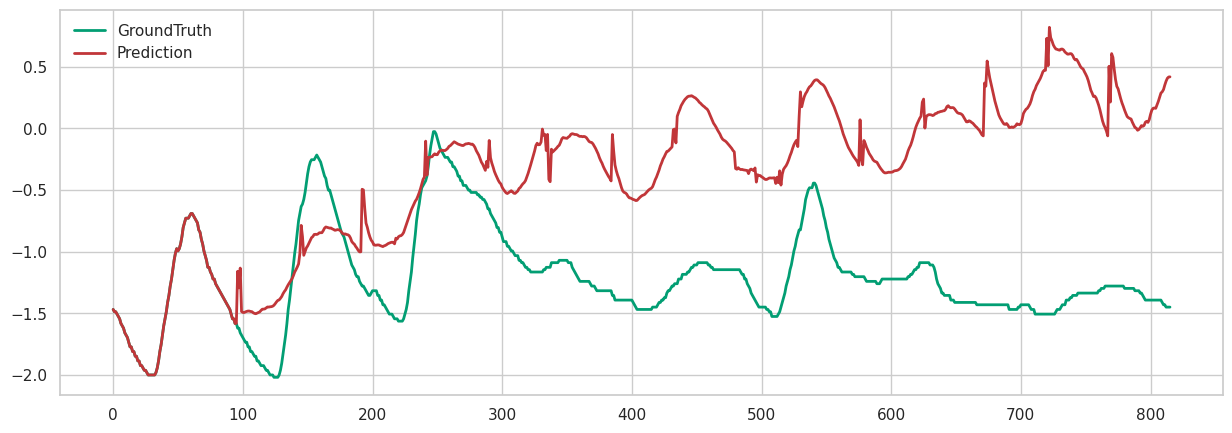

In [62]:
%%time
exp.test(setting)
torch.cuda.empty_cache()

---
## Compare Results of `ETTm2`with [Zeng · 2022](https://arxiv.org/abs/2205.13504) Paper

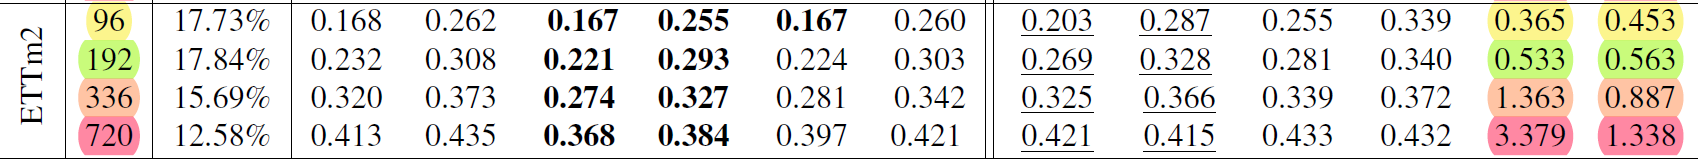

In [63]:
from IPython.display import Image
Image(filename=r"./Images/Informer Results ETTm2.png")

#### **Experiment Results**:
Comaparing my results with the paper resulted highlited in the image above.

| Seq_len | MSE | MAE |
|---|---|---|
| 96 | 3.426589250564575 | 1.6164441108703613 |
| 192 | 2.4573633670806885 | 1.2444374561309814 |
| 336 | 2.320659875869751 | 1.1376394033432007 |
| 720 | 3.672842502593994 | 1.5754497051239014 |


In [64]:
!zip Informer_results.zip /kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/results/*/*

  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/results/informer_train_on_ETTh1_192/metrics.npy (deflated 40%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/results/informer_train_on_ETTh1_192/pred.npy (deflated 10%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/results/informer_train_on_ETTh1_192/true.npy (deflated 99%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/results/informer_train_on_ETTh1_336/metrics.npy (deflated 40%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/results/informer_train_on_ETTh1_336/pred.npy (deflated 8%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/results/informer_train_on_ETTh1_336/true.npy (deflated 99%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long

In [65]:
!zip Informer_test_results.zip /kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/test_results/*/*

  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/test_results/informer_train_on_ETTh1_192/last_batch.pdf (deflated 22%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/test_results/informer_train_on_ETTh1_336/last_batch.pdf (deflated 18%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/test_results/informer_train_on_ETTh1_720/last_batch.pdf (deflated 14%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/test_results/informer_train_on_ETTh1_96/last_batch.pdf (deflated 23%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/test_results/informer_train_on_ETTh2_192/last_batch.pdf (deflated 23%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/test_results/informer_train_on_ETTh2_336/last_batch.pdf (deflated 19%)
  add

In [67]:
!zip Informer_checkpoints.zip /kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/Checkpoints/*/*

  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/Checkpoints/Informer_checkpoints/informer_train_on_ETTh1_192/ (stored 0%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/Checkpoints/Informer_checkpoints/informer_train_on_ETTh1_336/ (stored 0%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/Checkpoints/Informer_checkpoints/informer_train_on_ETTh1_720/ (stored 0%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/Checkpoints/Informer_checkpoints/informer_train_on_ETTh1_96/ (stored 0%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/Checkpoints/Informer_checkpoints/informer_train_on_ETTh2_192/ (stored 0%)
  adding: kaggle/working/Transformer-based-solutions-for-the-long-term-time-series-forecasting/Checkpoints/Informer_checkpoints/informer_train_on_ETTh2_336/